In [3]:
# ------ River imports ---------

from river import stream

# Metrics
from river.metrics import Accuracy, Precision, Recall, F1, CohenKappa, BalancedAccuracy

# Drift Detectors
from river.drift import ADWIN, KSWIN, PageHinkley, DriftRetrainingClassifier
from river.drift.binary import *

# Classifiers
from river.linear_model import LogisticRegression
from river.forest import ARFClassifier
from river.tree import HoeffdingTreeClassifier, ExtremelyFastDecisionTreeClassifier

In [4]:
# ------ Sk-learn imports -------------

# sklearn classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Sklearn Metric
from sklearn.metrics import cohen_kappa_score, accuracy_score, f1_score

# Others
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [5]:
# ------ Basic python lib imports ----------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
import mplcursors
from collections import deque
import warnings
from scipy.stats import ks_2samp

warnings.filterwarnings("ignore")

# %matplotlib inline
# mpld3.enable_notebook()

In [6]:
# ------ Get "cfpdss" data --------------------------
df_cfpdss = pd.read_csv(
    "C:/Users/HP/Desktop/github-aditya0by0/stream-viz/data/cfpdss.csv"
)
df_cfpdss.head()

,c5,c6,c7,c8,c9,n0,n1,n2,n3,n4,class
0,a,a,b,a,a,0.448573,1.212644,2.555515,0.242702,0.697604,A
1,a,a,a,b,b,1.902515,-0.467349,-0.744523,-0.017156,-0.380288,A
2,a,a,a,b,b,0.825045,1.002267,1.972207,-0.790095,0.233456,B
3,a,a,a,b,b,-0.124974,0.902601,1.696092,-0.320182,0.243261,A
4,b,a,a,b,a,-1.259765,0.793134,1.547527,-2.132172,-0.788367,B


In [7]:
# ------ Get cfpdss data with missing values
df_cfpdss_missing = pd.read_csv(
    "C:/Users/HP/Desktop/github-aditya0by0/stream-viz/data/cfpdss_m0.5.csv"
)
df_cfpdss_missing = df_cfpdss_missing.iloc[:, 1:]
df_cfpdss_missing.iloc[49:55]

,c5,c6,c7,c8,c9,n0,n1,n2,n3,n4,class
49,a,a,a,a,a,-0.192318,0.714631,1.188953,2.146077,1.393357,0
50,NaN,a,a,NaN,NaN,0.178767,NaN,NaN,NaN,0.269626,0
51,NaN,a,a,a,NaN,1.364684,-0.428681,NaN,1.122679,NaN,0
52,NaN,b,b,NaN,NaN,-0.878532,2.046157,4.402366,-0.633157,0.579233,0
53,NaN,NaN,NaN,a,a,0.794489,-1.089565,NaN,0.096427,NaN,1
54,NaN,NaN,a,a,NaN,NaN,NaN,NaN,0.282534,NaN,0


In [8]:
def data_encoding(data, feature_scaling=True):
    X_df = data.drop(columns="class")

    # Separating categorical and non-categorical columns
    categorical_columns = X_df.select_dtypes(include=["object"]).columns.tolist()
    X_df_categorical = X_df[categorical_columns]
    non_cat_columns = [col for col in X_df.columns if col not in categorical_columns]
    X_df_non_categorical = X_df[non_cat_columns]

    # Record the indices of missing values for each categorical feature
    missing_indices = {
        col: X_df_categorical[col].index[X_df_categorical[col].isna()].tolist()
        for col in categorical_columns
    }

    # Impute NaN values in categorical features with the most frequent value from the same column
    X_df_categorical = X_df_categorical.apply(
        lambda col: col.fillna(
            col.mode()[0] if not col.mode().empty else col.value_counts().index[0]
        )
    )

    # One hot encoding - Categorical data
    encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
    one_hot_encoded = encoder.fit_transform(X_df_categorical)
    columns = encoder.get_feature_names_out(categorical_columns)
    X_df_cat_one_hot = pd.DataFrame(
        one_hot_encoded, columns=columns, index=X_df_categorical.index
    )

    # Replace the imputed values back with NaNs in the encoded DataFrame
    for col, indices in missing_indices.items():
        for index in indices:
            cols_to_check = [c for c in X_df_cat_one_hot.columns if c.startswith(col)]
            for c in cols_to_check:
                X_df_cat_one_hot.at[index, c] = np.nan

    # Feature scaling numerical data/non-categorical data
    if feature_scaling:
        scaler = MinMaxScaler()
        X_df_non_categorical = pd.DataFrame(
            scaler.fit_transform(X_df_non_categorical),
            columns=X_df_non_categorical.columns,
            index=X_df_non_categorical.index,
        )

    # Concatenate categorical and non-categorical data
    X_df_encoded = pd.concat(
        [
            X_df_cat_one_hot,
            X_df_non_categorical,
            # X_df_categorical  # Re-add the original categorical columns with NaNs
        ],
        axis=1,
    )

    # Encoding the target variable
    y_df = data[["class"]]
    y_encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
    y_one_hot = y_encoder.fit_transform(y_df)
    y_encoded = pd.Series(y_one_hot.ravel())

    return X_df_encoded, y_encoded

In [9]:
# ------ Encode missing and non-missing ddata
# X_df_encoded, y_encoded =  data_encoding(df_cfpdss)
X_df_encoded_m, y_encoded_m = data_encoding(df_cfpdss_missing)

In [10]:
import importlib
import DataMissingness

importlib.reload(DataMissingness)

<module 'DataMissingness' from 'C:\\Users\\HP\\Desktop\\github-aditya0by0\\stream-viz\\notebooks\\DataMissingness.py'>

In [11]:
def calculate_missigness_score(X_df_m, window_size=100):
    missigness_detector = DataMissingness.MissingnessDetector(window_size=100)
    for idx, xi in X_df_m.iterrows():
        missigness_detector.update(xi.to_dict(), idx=idx)

    return missigness_detector.get_results()


result = calculate_missigness_score(X_df_encoded_m.iloc[:1000])

In [17]:
from pyampute.exploration.mcar_statistical_tests import MCARTest

mcar_little_test_cls = MCARTest(method="little")
mcar_little_test_cls.little_mcar_test(X_df_encoded_m)

0.25248217532242956

In [18]:
X_df_encoded_m.iloc[99:300].isnull().sum()

c5_b    109
c6_b     92
c7_b    100
c8_b    102
c9_b    104
n0      101
n1       95
n2      106
n3       97
n4       91
dtype: int64

In [19]:
result["MCAR (Chi2 Test)"].head()

NameError: name 'result' is not defined

In [ ]:
mcar_little_test_cls.little_mcar_test(X_df_encoded_m.iloc[99:199])

In [ ]:
p_values[p_values["p_value"] <= 0.05]

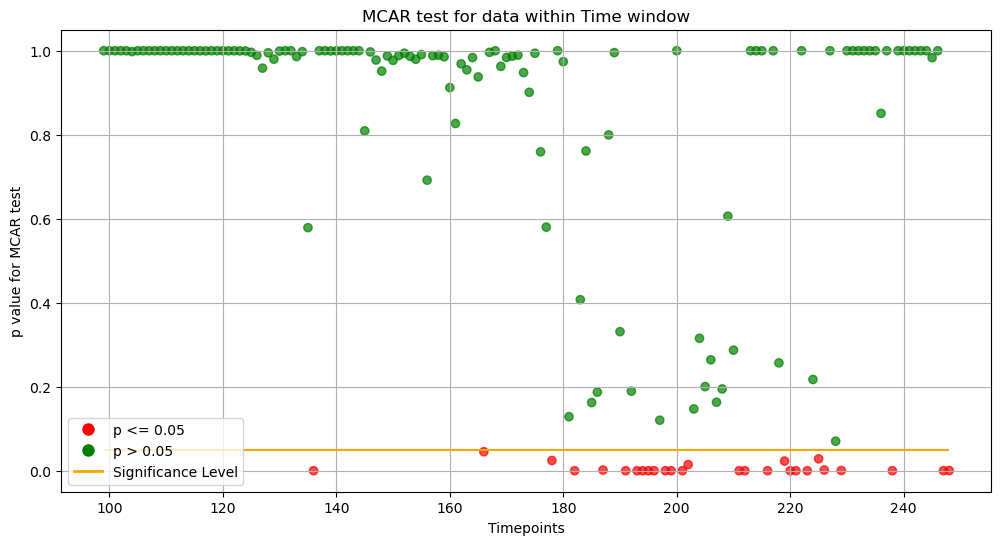

In [20]:
import matplotlib.pyplot as plt

# Assuming `p_values` is a DataFrame and the p-values are in a column named 'p_value'
p_values_column = (
    p_values["p_value"] if "p_value" in p_values.columns else p_values.iloc[:, 0]
)

# Define colors based on the p-value threshold
colors = ["red" if p <= 0.05 else "green" for p in p_values_column]

# Create the scatter plot
plt.figure(figsize=(12, 6))
plt.hlines(
    0.05,
    xmin=p_values_column.index[0],
    xmax=p_values_column.index[-1],
    colors="orange",
    label="Significance Level",
)
plt.scatter(p_values.index, p_values_column, c=colors, alpha=0.7)

# Create custom legend handles
red_patch = plt.Line2D(
    [0],
    [0],
    marker="o",
    color="w",
    markerfacecolor="red",
    markersize=10,
    label="p <= 0.05",
)
green_patch = plt.Line2D(
    [0],
    [0],
    marker="o",
    color="w",
    markerfacecolor="green",
    markersize=10,
    label="p > 0.05",
)

# Add legend
plt.legend(
    handles=[
        red_patch,
        green_patch,
        plt.Line2D([0], [0], color="orange", lw=2, label="Significance Level"),
    ]
)

# Add labels and title
plt.ylabel("p value for MCAR test")
plt.xlabel("Timepoints")
plt.title("MCAR test for data within Time window")
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# len(result['MAR'])
result["MNAR"].head()

In [ ]:
len(result["MCAR (Random Test)"])

In [ ]:
len(result["MNAR"])

In [ ]:
# Assuming result is your dictionary containing MAR, MCAR (Random Test), and MNAR scores
def plot_missigness(result, start_tp=0, end_tp=1000):
    # Plot MAR mean score
    MAR_df = result["MAR"].iloc[start_tp:end_tp]
    MCAR_df = result["MCAR (Random Test)"].iloc[start_tp:end_tp]
    MNAR_df = result["MNAR"].iloc[start_tp:end_tp]

    plt.figure(figsize=(10, 6))
    plt.plot(MAR_df.index, MAR_df["mean"], color="blue", label="MAR mean score")

    # Plot MCAR (Random Test) mean score
    plt.plot(
        MCAR_df.index,
        MCAR_df["mean"],
        color="green",
        label="MCAR (Random Test) mean score",
    )

    # Plot MNAR score
    plt.plot(MNAR_df.index, MNAR_df["mean"], color="yellow", label="MNAR score")

    plt.title("Missing Data Type Score vs. Time")
    plt.xlabel("Time")
    plt.ylabel("Score")
    plt.grid(True)
    plt.xticks(
        np.arange(start_tp, end_tp, (end_tp - start_tp) // 10)
    )  # Assuming 'MAR' is used as the index for x-axis ticks
    plt.legend()
    plt.show()


plot_missigness(result, start_tp=1000, end_tp=2000)

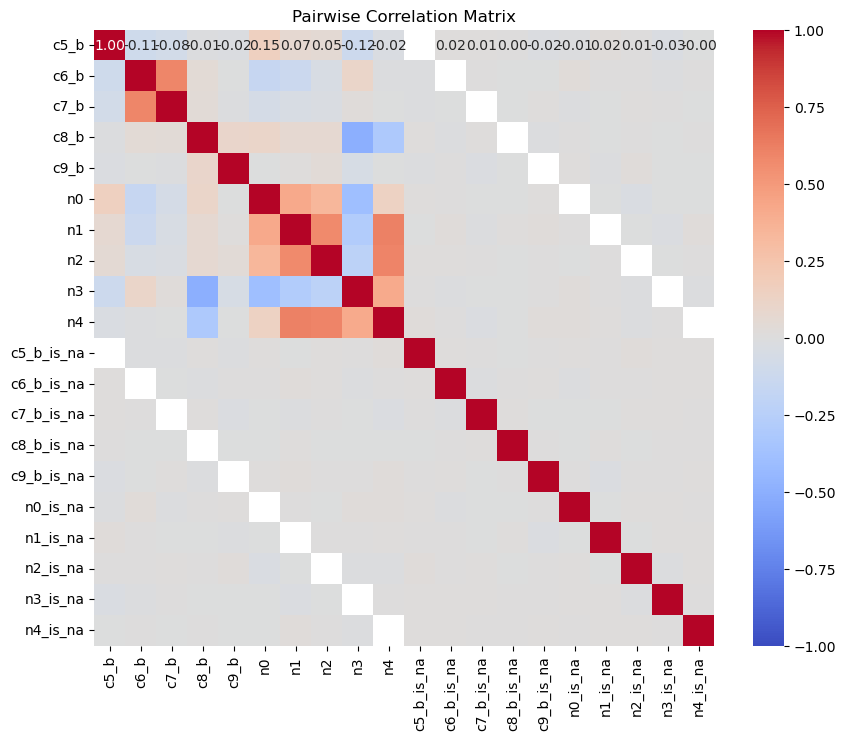

In [23]:
"Source : - https://stackoverflow.com/questions/76739357/how-to-test-missing-at-random-mar-in-r"
X_df_encoded_m_ind = X_df_encoded_m.copy(deep=True)
for col in X_df_encoded_m.columns:
    X_df_encoded_m_ind[col + "_is_na"] = X_df_encoded_m_ind[col].isna().astype(int)

# Generate plot of pairwise correlations
correlation_matrix = X_df_encoded_m_ind.corr(method="pearson")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Pairwise Correlation Matrix")
plt.show()
# pearson works only for cont. data
# binning and purity - cat
# DTs

In [26]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

# Assuming X_df_encoded_m and y_encoded_m are your data
# and they are properly encoded and prepared.

# Train the decision tree
clf_dt = DecisionTreeClassifier(criterion="entropy", max_depth=2)
clf_dt.fit(X_df_encoded_m.filter(regex="^n")[:1000], y_encoded_m[:1000])

# Extract the decision thresholds from the tree
thresholds = clf_dt.tree_.threshold[clf_dt.tree_.threshold > -2]
thresholds = np.sort(thresholds)
thresholds

array([0.42203587, 0.43919723, 0.55094236])

[Text(0.5, 0.8333333333333334, 'x[4] <= 0.551\nentropy = 0.993\nsamples = 1000\nvalue = [548, 452]'),
 Text(0.25, 0.5, 'x[4] <= 0.439\nentropy = 0.988\nsamples = 774\nvalue = [338.0, 436.0]'),
 Text(0.125, 0.16666666666666666, 'entropy = 0.285\nsamples = 121\nvalue = [6, 115]'),
 Text(0.375, 0.16666666666666666, 'entropy = 1.0\nsamples = 653\nvalue = [332, 321]'),
 Text(0.75, 0.5, 'x[2] <= 0.422\nentropy = 0.369\nsamples = 226\nvalue = [210, 16]'),
 Text(0.625, 0.16666666666666666, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.875, 0.16666666666666666, 'entropy = 0.321\nsamples = 223\nvalue = [210, 13]')]

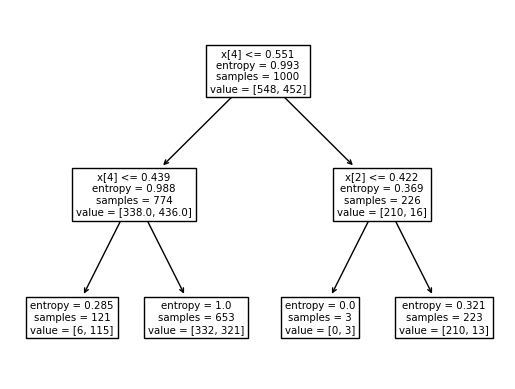

In [27]:
from sklearn import tree

tree.plot_tree(clf_dt)

In [28]:
# Define a function to apply binning based on thresholds
def apply_binning(value, thresholds):
    # Filter out invalid thresholds
    for i, thresh in enumerate(thresholds):
        if value <= thresh:
            return i
    return len(thresholds)  # If value exceeds the last threshold


# Apply the binning to the entire dataset (or a subset of your choosing)
binned_data = X_df_encoded_m.filter(regex="^n").applymap(
    lambda x: apply_binning(x, thresholds)
)

# Example to view the binned data
binned_data.head()

,n0,n1,n2,n3,n4
0,2,3,2,2,3
1,3,1,2,2,2
2,3,3,2,0,2
3,2,3,2,0,3
4,0,3,2,0,0


In [ ]:
binned_data.hist()

In [20]:
import pandas as pd
from scipy import stats

# Example data
data = {
    "Category": ["A", "A", "B", "B", "C", "C", "C", "C"],
    "Numerical": [23, 45, 12, 36, 72, 58, 91, 62],
}

df = pd.DataFrame(data)

# Bin the numerical data
df["Numerical_binned"] = pd.qcut(df["Numerical"], q=4)

# Create a contingency table
contingency_table = pd.crosstab(df["Category"], df["Numerical_binned"])

# Perform Chi-Square test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(contingency_table)

print("Chi-Square statistic:", chi2_stat)
print("Chi-Square p-value:", p_val)

Chi-Square statistic: 8.0
Chi-Square p-value: 0.23810330555354436


In [30]:
# categorical vs is_null_categorical (categorical) = chi2
# numerical vs is_null_numerical (categorical) =
# categorical vs

# cat , num, is_cat_null, is_num_null

# cat vs is_cat_null - chi2
# cat vs is_num_null - chi2
# binned_num vs is_cat_null - binning + chi2
# binned_num vs is_num_null - binning + chi2
X_df_encoded_m.filter(regex="^n").columns

Index(['n0', 'n1', 'n2', 'n3', 'n4'], dtype='object')

In [52]:
X_df_encoded_m.isna().sum()

c5_b    6545
c6_b    6418
c7_b    6433
c8_b    6485
c9_b    6632
n0      6514
n1      6495
n2      6474
n3      6488
n4      6541
dtype: int64

In [53]:
X_df_encoded_m_ind = X_df_encoded_m.copy(deep=True)
for col in X_df_encoded_m.columns:
    X_df_encoded_m_ind["is_na_" + col] = X_df_encoded_m_ind[col].isna().astype(int)
for col in X_df_encoded_m.filter(regex="^n").columns:
    X_df_encoded_m_ind["bin_idx_" + col] = X_df_encoded_m[col].apply(
        lambda x: apply_binning(x, thresholds)
    )
X_df_encoded_m_ind.head()

,c5_b,c6_b,c7_b,c8_b,c9_b,n0,n1,n2,n3,n4,...,is_na_n0,is_na_n1,is_na_n2,is_na_n3,is_na_n4,bin_idx_n0,bin_idx_n1,bin_idx_n2,bin_idx_n3,bin_idx_n4
0,0.0,0.0,1.0,0.0,0.0,0.530356,0.598345,0.519161,0.478557,0.620371,...,0,0,0,0,0,2,3,2,2,3
1,0.0,0.0,0.0,1.0,1.0,0.672618,0.423329,0.442055,0.449888,0.458838,...,0,0,0,0,0,3,1,2,2,2
2,0.0,0.0,0.0,1.0,1.0,0.567192,0.576429,0.505532,0.364614,0.550814,...,0,0,0,0,0,3,3,2,0,2
3,0.0,0.0,0.0,1.0,1.0,0.474236,0.566046,0.499081,0.416457,0.552283,...,0,0,0,0,0,2,3,2,0,3
4,1.0,0.0,0.0,1.0,0.0,0.363202,0.554642,0.495610,0.216550,0.397683,...,0,0,0,0,0,0,3,2,0,0


In [55]:
categorical_columns = X_df_encoded_m_ind.filter(regex="^c\d*").columns
binned_numerical_columns = X_df_encoded_m_ind.filter(regex="bin_idx*n*").columns
binned_numerical_columns

Index(['bin_idx_n0', 'bin_idx_n1', 'bin_idx_n2', 'bin_idx_n3', 'bin_idx_n4'], dtype='object')

In [58]:
is_na_columns = X_df_encoded_m_ind.filter(regex="is_na_*\d*").columns
is_na_columns

Index(['is_na_c5_b', 'is_na_c6_b', 'is_na_c7_b', 'is_na_c8_b', 'is_na_c9_b',
       'is_na_n0', 'is_na_n1', 'is_na_n2', 'is_na_n3', 'is_na_n4'],
      dtype='object')

In [63]:
col_list = list(categorical_columns) + list(binned_numerical_columns)
col_list

['c5_b',
 'c6_b',
 'c7_b',
 'c8_b',
 'c9_b',
 'bin_idx_n0',
 'bin_idx_n1',
 'bin_idx_n2',
 'bin_idx_n3',
 'bin_idx_n4']

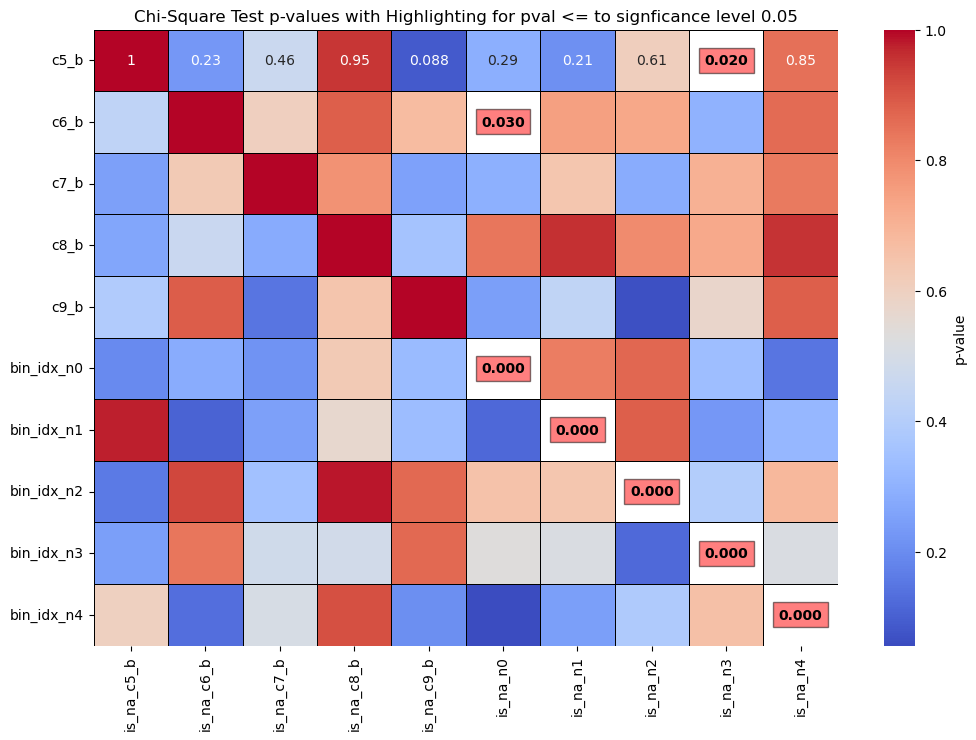

In [76]:
# cat vs is_cat_null - chi2
# cat vs is_num_null - chi2
# binned_num vs is_cat_null - binning + chi2
# binned_num vs is_num_null - binning + chi2
p_value_matrix = pd.DataFrame(index=col_list, columns=is_na_columns)
col_list = list(categorical_columns) + list(binned_numerical_columns)
for col1 in col_list:
    for col2 in is_na_columns:
        # Create a contingency table
        # print(f"for {col1} with {col2}")
        contingency_table = pd.crosstab(
            X_df_encoded_m_ind[col1], X_df_encoded_m_ind[col2]
        )
        # Perform Chi-Square test
        chi2_stat, p_val, dof, ex = stats.chi2_contingency(contingency_table)
        p_value_matrix.loc[col1, col2] = p_val

# Convert p-values to float
p_value_matrix = p_value_matrix.astype(float)

# Create a mask for p-values <= 0.05

significance_level = 0.05
mask = p_value_matrix <= significance_level

# Create a heatmap with highlighting
plt.figure(figsize=(12, 8))
sns.heatmap(
    p_value_matrix,
    annot=True,
    cmap="coolwarm",
    cbar_kws={"label": "p-value"},
    mask=mask,
    linewidths=0.5,
    linecolor="black",
    annot_kws={"size": 10},
)
# Highlight cells with p-value <= 0.05 with a different annotation
for i in range(p_value_matrix.shape[0]):
    for j in range(p_value_matrix.shape[1]):
        if p_value_matrix.iloc[i, j] <= 0.05:
            plt.text(
                j + 0.5,
                i + 0.5,
                f"{p_value_matrix.iloc[i, j]:.3f}",
                horizontalalignment="center",
                verticalalignment="center",
                # color='white',
                fontsize=10,
                weight="bold",
                bbox=dict(facecolor="red", alpha=0.5),
            )

plt.title(
    f"Chi-Square Test p-values with Highlighting for pval <= to signficance level {significance_level}"
)
plt.show()